In [1]:
from meld_graph.dataset import GraphDataset
from meld_graph import experiment

/home/kw350/.conda/envs/meld_graph/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setting MELD_DATA_PATH to /rds/user/kw350/rds-kw350-meld/meld_data/Data/
Setting BASE_PATH to /rds/user/kw350/rds-kw350-meld/meld_data/Data/
Setting EXPERIMENT_PATH to /rds/user/kw350/rds-kw350-meld/experiments/kw350/
No fs_subjects_path defined in /home/kw350/software/gdl/meld_classifier/meld_config.ini!
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments_graph/kw350


In [2]:

def load_config(config_file):
    """load config.py file and return config object"""
    import importlib.machinery, importlib.util
    loader = importlib.machinery.SourceFileLoader("config", config_file)
    spec = importlib.util.spec_from_loader(loader.name, loader)
    config = importlib.util.module_from_spec(spec)
    loader.exec_module(config)
    return config

In [3]:
config = load_config('../scripts/config_files/experiment_config_konrad_synth.py')

cur_data_parameters = config.data_parameters
cur_network_parameters = config.network_parameters


In [4]:
exp = experiment.Experiment(cur_network_parameters, cur_data_parameters)

saving parameter files to /rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/22-08-19_synth_unet_gamma_2/fold_00
Initialised Experiment 22-08-19_synth_unet_gamma_2


In [5]:
train_dset = GraphDataset.from_experiment(exp, mode='train')

getting train val test split
total number of subjects: 46
total number of subjects after restricting to subjects from MELD_dataset_V6.csv: 46
total number of subjects: 950
total number of subjects after restricting to subjects from MELD_dataset_V6.csv: 942
total number after filtering by scanner ['3T', '15T'], features, lesional_only True: 911
full_feature_list: ['.combat.on_lh.curv.sm5.mgh', '.combat.on_lh.gm_FLAIR_0.25.sm10.mgh', '.combat.on_lh.gm_FLAIR_0.5.sm10.mgh', '.combat.on_lh.gm_FLAIR_0.75.sm10.mgh', '.combat.on_lh.gm_FLAIR_0.sm10.mgh', '.combat.on_lh.pial.K_filtered.sm20.mgh', '.combat.on_lh.sulc.sm5.mgh', '.combat.on_lh.thickness.sm10.mgh', '.combat.on_lh.w-g.pct.sm10.mgh', '.combat.on_lh.wm_FLAIR_0.5.sm10.mgh', '.combat.on_lh.wm_FLAIR_1.sm10.mgh', '.inter_z.asym.intra_z.combat.on_lh.curv.sm5.mgh', '.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.25.sm10.mgh', '.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.5.sm10.mgh', '.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.75.sm10.mgh

In [6]:
len(train_dset)

40

In [7]:
lesions=[]
for d in train_dset:
    lesions.append(int(d['y'].sum()))

(array([12.,  7.,  2.,  3.,  0.,  1.,  2.,  0.,  2.,  0.,  1.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([    0.  ,   307.68,   615.36,   923.04,  1230.72,  1538.4 ,
         1846.08,  2153.76,  2461.44,  2769.12,  3076.8 ,  3384.48,
         3692.16,  3999.84,  4307.52,  4615.2 ,  4922.88,  5230.56,
         5538.24,  5845.92,  6153.6 ,  6461.28,  6768.96,  7076.64,
         7384.32,  7692.  ,  7999.68,  8307.36,  8615.04,  8922.72,
         9230.4 ,  9538.08,  9845.76, 10153.44, 10461.12, 10768.8 ,
        11076.48, 11384.16

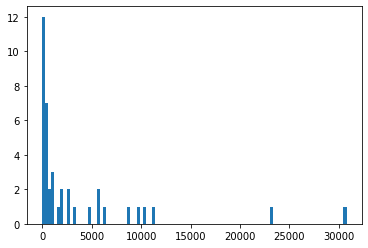

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(lesions,100)

40

In [26]:
import numpy as np
l_f_means=np.zeros((len(lesions),33))
p_f_means=np.zeros((len(lesions),33))
for si,s in enumerate(train_dset):
    if s['y'].sum()>0:
        l_f_means[si] = s['x'][s['y']==1].mean(axis=0)
    rand_i = np.random.choice(len(lesions))
    p_f_means[si] = train_dset[rand_i]['x'][s['y']==1].mean(axis=0)

In [27]:
import seaborn as sns

Text(0.5, 0.89, 'Synthetic')

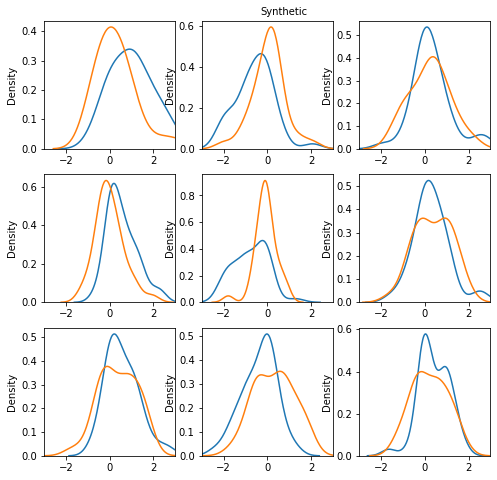

In [28]:
fig,axes = plt.subplots(3,3,figsize=(8,8))
axes=axes.ravel()
for r in np.arange(9):
    sns.kdeplot(l_f_means[:,r],ax=axes[r])
    sns.kdeplot(p_f_means[:,r],ax=axes[r])
    axes[r].set_xlim([-3,3])
fig.text(0.5, 0.89,'Synthetic')

In [14]:
import matplotlib_surface_plotting as msp
from meld_graph.icospheres import IcoSpheres


In [15]:
icos= IcoSpheres(conv_type='SpiralConv')


Using coord type pseudo


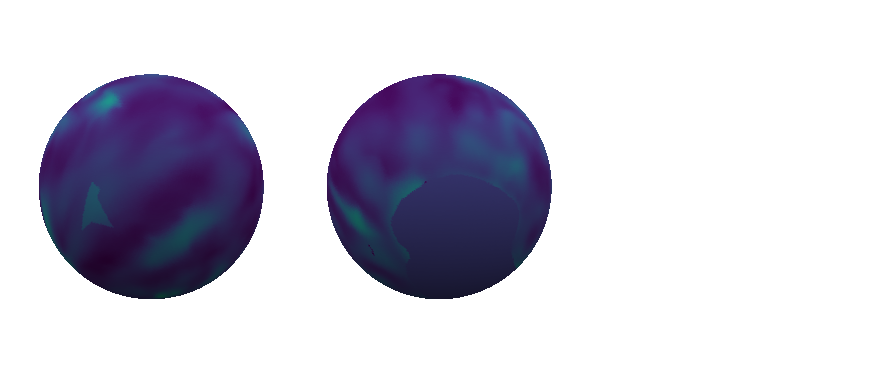

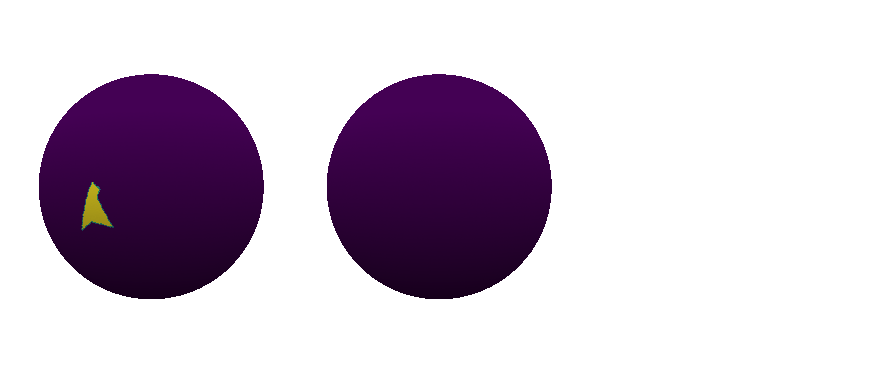

In [29]:
s=train_dset[10]
c=np.array(s['x'][:,0])
msp.plot_surf(icos.icospheres[7]['coords'],
                 icos.icospheres[7]['faces'],
                  c,
                  colorbar=False
                 )
lesion=np.array(s['y']).astype(bool)
msp.plot_surf(icos.icospheres[7]['coords'],
                 icos.icospheres[7]['faces'],
                  lesion,
                  colorbar=False
                 )

In [ ]:
coords = icos.icospheres[7]['spherical_coords']
from sklearn.metrics import pairwise_distances
pairwise_distances(coords[~lesion],coords[lesion], metric='haversine')[0]

In [ ]:
def clockwiseangle_and_distance(point,origin):
        import math

        refvec = [0, 1]
        # Vector between point and the origin: v = p - o
        vector = [point[0]-origin[0], point[1]-origin[1]]
        # Length of vector: ||v||
        lenvector = math.hypot(vector[0], vector[1])
        # If length is zero there is no angle
        if lenvector == 0:
            return -math.pi, 0
        # Normalize vector: v/||v||
        normalized = [vector[0]/lenvector, vector[1]/lenvector]
        dotprod  = normalized[0]*refvec[0] + normalized[1]*refvec[1]     # x1*x2 + y1*y2
        diffprod = refvec[1]*normalized[0] - refvec[0]*normalized[1]     # x1*y2 - y1*x2
        angle = math.atan2(diffprod, dotprod)
        # Negative angles represent counter-clockwise angles so we need to subtract them 
        # from 2*pi (360 degrees)
        if angle < 0:
            return 2*math.pi+angle, lenvector
        # I return first the angle because that's the primary sorting criterium
        # but if two vectors have the same angle then the shorter distance should come first.
        return angle, lenvector

In [ ]:
import matplotlib.path as mpltPath

radius=0.2
f_radius = np.clip(np.random.normal(radius,radius/2),0.05,2)

com_i = np.random.choice(len(coords))
origin = coords[com_i]
distances = pairwise_distances(origin.reshape(-1,1).T,coords, metric='haversine')[0]
n_points = np.random.choice(6)+4
subset = coords[distances<f_radius]
poly_i = np.random.choice(len(subset),n_points)
polygon = subset[poly_i]
polygon = np.array(sorted(polygon, key=lambda point: clockwiseangle_and_distance(point,origin)))
path = mpltPath.Path(polygon)
lesion = path.contains_points(coords)

In [ ]:
np.logical_and(distances<f_radius,~lesion).shape

In [ ]:
ds=pairwise_distances(coords[np.logical_and(distances<f_radius,~lesion)],coords[lesion], metric='haversine')


In [ ]:
in_dists = np.min(ds,axis=0)
in_dists = in_dists/np.max(in_dists)
#in_dists=np.clip(in_dists,0,0.02)
out_dists = np.min(ds,axis=1)
out_dists = out_dists/np.max(out_dists)
#out_dists = np.clip(out_dists,0,0.02)

In [ ]:
dist_m = np.zeros(len(lesion))
dist_m[lesion]=in_dists
dist_m[np.logical_and(distances<f_radius,~lesion)] = -out_dists


In [ ]:
msp.plot_surf(icos.icospheres[7]['coords'],
                 icos.icospheres[7]['faces'],
                  dist_m,
                  colorbar=False,
              rotate=180
                 )

In [ ]:
from scipy import interpolate
subset = np.arange(10242)
f = interpolate.interp2d(coords[subset,0],coords[subset,1],
                         lesion[subset].astype(int), kind='quintic')

xnew = np.linspace(-np.pi/2,np.pi/2,100)
ynew = np.linspace(-np.pi,np.pi,200)
znew = f(xnew, ynew)

In [ ]:
lesion

In [ ]:
plt.imshow(znew)

In [ ]:
z = 1/(1 + np.exp(-dist_m[m]*10))

In [ ]:
def sigmoid_dists(dists):
    m = dists==0
    z = 1/(1 + np.exp(-dists*10))
    z[m]=0
    return z

In [ ]:
plt.scatter(dist_m[m],z)

In [ ]:
smoothed_mask = sigmoid_dists(dist_m)

In [ ]:
msp.plot_surf(icos.icospheres[7]['coords'],
                 icos.icospheres[7]['faces'],
                  smoothed_mask,
                  colorbar=False,
              rotate=180
                 )

In [ ]:
plt.hist(smoothed_mask,100)